<a href="https://colab.research.google.com/github/SLokesh1810/mental_health_detector/blob/main/PHQ9_DepressionDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MENTAL HEALTH DETECTOR**
  **Objective:** To detect mental state of a preson with a finite number of questions. The main motive of the model is to make them as optimal as we can, i.e, to have the least number of questions to prediction predict the appropriate mental state.

  For this, we use a **PHQ-9 (Patient Health Questionnaire)** detection system, which is basic model prepared to check the mental state of a patient. It consists of 9 questions to classify between 5 depression i.e,

1.   No depression (0-4)
2.   Mild depression (5-9)
3.   Moderate depression (10-14)
4.   Moderately severe (15-19)
5.   Severe depression (20-27)


## **IMPORTING MODULES**

In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from imblearn.pipeline import Pipeline

## **IMPORTING DATASET**

In [241]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [242]:
df = pd.read_csv('/content/drive/MyDrive/CSV files/PHQ9_Dataset.csv')
df

,Age,Gender,Little interest or pleasure in doing things?,"Feeling down, depressed, or hopeless?","Trouble falling or staying asleep, or sleeping too much?",Feeling tired or having little energy?,Poor appetite or overeating?,Feeling bad about yourself — or that you are a failure or have let yourself or your family down?,"Trouble concentrating on things, such as reading the newspaper or watching television?",Moving or speaking so slowly that other people could have noticed? Or the opposite — being so fidgety or restless that you have been moving around a lot more than usual?,"Thoughts that you would be better off dead, or thoughts of hurting yourself in some way?",PHQ-9 Total Score,Depression Level
0,22,Male,Not at all,Several days,Not at all,Several days,Not at all,More than half the days,More than half the days,Several days,Not at all,7,Mild
1,25,Male,Several days,Nearly every day,More than half the days,Several days,Several days,More than half the days,Nearly every day,Nearly every day,Nearly every day,19,Moderately Severe
2,25,Male,Nearly every day,Several days,Nearly every day,Nearly every day,More than half the days,Nearly every day,More than half the days,Nearly every day,Not at all,20,Severe
3,26,Male,Nearly every day,Not at all,Nearly every day,Nearly every day,More than half the days,Nearly every day,Not at all,Not at all,Nearly every day,17,Moderately Severe
4,19,Male,More than half the days,Several days,More than half the days,More than half the days,Nearly every day,Several days,Nearly every day,Nearly every day,Nearly every day,20,Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,23,Female,Several days,More than half the days,More than half the days,Nearly every day,Nearly every day,More than half the days,Nearly every day,More than half the days,Several days,19,Moderately Severe
396,20,Male,Several days,More than half the days,Nearly every day,Several days,Nearly every day,Not at all,Several days,Nearly every day,More than half the days,16,Moderately Severe
397,20,Female,Several days,Not at all,More than half the days,More than half the days,More than half the days,Not at all,More than half the days,More than half the days,More than half the days,13,Moderate
398,24,Male,Nearly every day,More than half the days,Nearly every day,More than half the days,More than half the days,More than half the days,Several days,Not at all,Nearly every day,18,Moderately Severe


## **DATA PREPROCESSING**

In [243]:
# We want the model to generate predictions for all the adults but this dataset contains people who are in the 20's and 30's
df = df.drop('Age',axis=1)

### Convertion to categories

In [244]:
# For responses
df['Little interest or pleasure in doing things?'].value_counts()
convertionDict = {'Nearly every day': 3, 'Several days': 1, 'Not at all': 0, 'More than half the days': 2}
for i in df.columns[1:-2]:
  df[i] = df[i].map(convertionDict)

# For depression level
df['Depression Level'].value_counts()
dLevelConversion = {'Minimal': 0, 'Mild': 1, 'Moderate': 2, 'Moderately Severe': 3, 'Severe': 4}
df['Depression Level'] = df['Depression Level'].map(dLevelConversion)

# For gender
genderConversion = {'Female': 0, 'Male': 1}
df['Gender'] = df['Gender'].map(genderConversion)

### Dataset after all preprocessing and conversions

In [245]:
df

,Gender,Little interest or pleasure in doing things?,"Feeling down, depressed, or hopeless?","Trouble falling or staying asleep, or sleeping too much?",Feeling tired or having little energy?,Poor appetite or overeating?,Feeling bad about yourself — or that you are a failure or have let yourself or your family down?,"Trouble concentrating on things, such as reading the newspaper or watching television?",Moving or speaking so slowly that other people could have noticed? Or the opposite — being so fidgety or restless that you have been moving around a lot more than usual?,"Thoughts that you would be better off dead, or thoughts of hurting yourself in some way?",PHQ-9 Total Score,Depression Level
0,1,0,1,0,1,0,2,2,1,0,7,1
1,1,1,3,2,1,1,2,3,3,3,19,3
2,1,3,1,3,3,2,3,2,3,0,20,4
3,1,3,0,3,3,2,3,0,0,3,17,3
4,1,2,1,2,2,3,1,3,3,3,20,4
...,...,...,...,...,...,...,...,...,...,...,...,...
395,0,1,2,2,3,3,2,3,2,1,19,3
396,1,1,2,3,1,3,0,1,3,2,16,3
397,0,1,0,2,2,2,0,2,2,2,13,2
398,1,3,2,3,2,2,2,1,0,3,18,3


## **Data Exploration and Visualization**

In [246]:
df.describe()

,Gender,Little interest or pleasure in doing things?,"Feeling down, depressed, or hopeless?","Trouble falling or staying asleep, or sleeping too much?",Feeling tired or having little energy?,Poor appetite or overeating?,Feeling bad about yourself — or that you are a failure or have let yourself or your family down?,"Trouble concentrating on things, such as reading the newspaper or watching television?",Moving or speaking so slowly that other people could have noticed? Or the opposite — being so fidgety or restless that you have been moving around a lot more than usual?,"Thoughts that you would be better off dead, or thoughts of hurting yourself in some way?",PHQ-9 Total Score,Depression Level
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.490000,1.512500,1.532500,1.562500,1.517500,1.550000,1.555000,1.547500,1.582500,1.555000,13.915000,2.385000
std,0.500526,1.123833,1.077891,1.148648,1.087497,1.120553,1.118079,1.104896,1.084497,1.131448,3.483261,0.763697
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000,2.000000
50%,0.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,14.000000,2.000000
75%,1.000000,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,3.000000,16.000000,3.000000
max,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,22.000000,4.000000


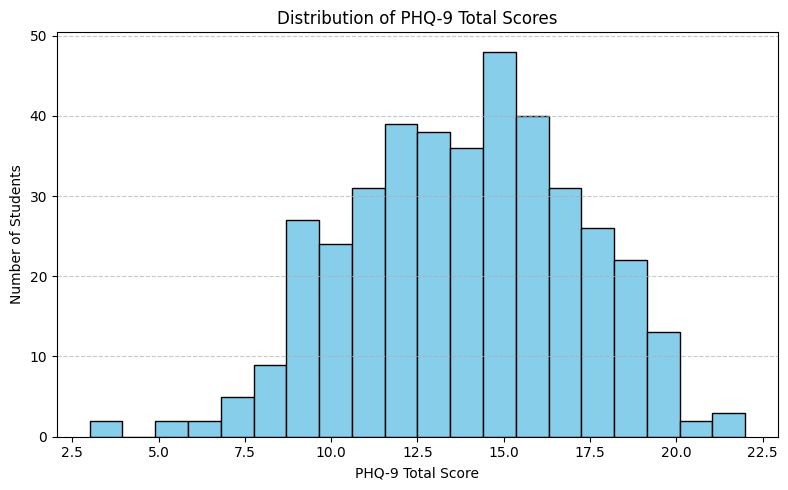

In [247]:
plt.figure(figsize=(8, 5))
plt.hist(df['PHQ-9 Total Score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of PHQ-9 Total Scores')
plt.xlabel('PHQ-9 Total Score')
plt.ylabel('Number of Students')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipython-input-3952737508.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Depression Level', order=df['Depression Level'].value_counts().index, palette='Set2')


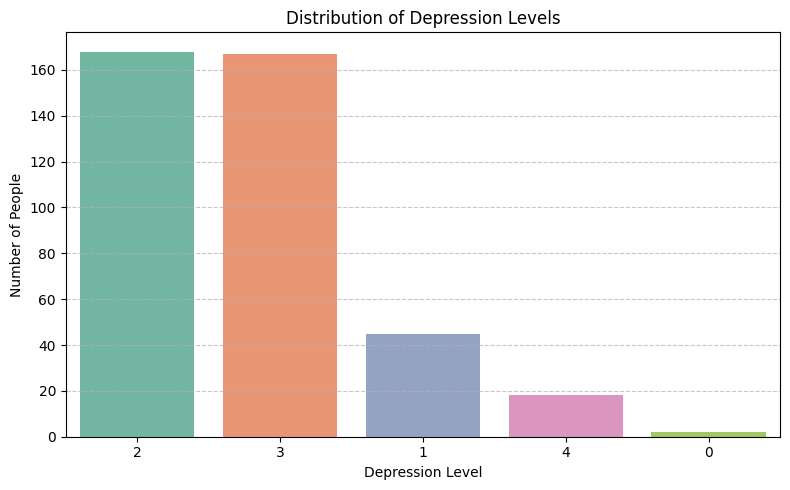

In [248]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Depression Level', order=df['Depression Level'].value_counts().index, palette='Set2')

plt.title('Distribution of Depression Levels')
plt.xlabel('Depression Level')
plt.ylabel('Number of People')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **RELATIONS BETWEEN COLUMN**

In [249]:
df = pd.DataFrame(df)
correlation_matrix = df.corr()
correlation_matrix['Depression Level'].sort_values(ascending=False)

,Depression Level
Depression Level,1.000000
PHQ-9 Total Score,0.925276
"Trouble falling or staying asleep, or sleeping too much?",0.369632
Poor appetite or overeating?,0.328892
"Feeling down, depressed, or hopeless?",0.328802
Little interest or pleasure in doing things?,0.327275
"Trouble concentrating on things, such as reading the newspaper or watching television?",0.325786
Moving or speaking so slowly that other people could have noticed? Or the opposite — being so fidgety or restless that you have been moving around a lot more than usual?,0.324681
"Thoughts that you would be better off dead, or thoughts of hurting yourself in some way?",0.314790
Feeling tired or having little energy?,0.296656


## **TRAINING THE MODEL**

In [250]:
# Removing the least co-related columns
colToRemove = ['Feeling tired or having little energy?',
              'Moving or speaking so slowly that other people could have noticed? Or the opposite — being so fidgety or restless that you have been moving around a lot more than usual?',
              'Feeling down, depressed, or hopeless?',
              'Feeling bad about yourself — or that you are a failure or have let yourself or your family down?',
              'PHQ-9 Total Score',
              'Gender']
dataTotrain = df.drop(columns=colToRemove)
dataTotrain

,Little interest or pleasure in doing things?,"Trouble falling or staying asleep, or sleeping too much?",Poor appetite or overeating?,"Trouble concentrating on things, such as reading the newspaper or watching television?","Thoughts that you would be better off dead, or thoughts of hurting yourself in some way?",Depression Level
0,0,0,0,2,0,1
1,1,2,1,3,3,3
2,3,3,2,2,0,4
3,3,3,2,0,3,3
4,2,2,3,3,3,4
...,...,...,...,...,...,...
395,1,2,3,3,1,3
396,1,3,3,1,2,3
397,1,2,2,2,2,2
398,3,3,2,1,3,3


### **Model 1**

### **Dataset Altering**

In [251]:
newConversion = {
    0: 0,   # Minimal → 0
    1: 1,   # Mild    → 1
    2: 1,   # Moderate → 1
    3: 2,   # Mod Severe → 2
    4: 2    # Severe → 2
}
dataTotrain = df.copy()
dataTotrain = dataTotrain.drop(columns=colToRemove)
dataTotrain['Depression Level'] = dataTotrain['Depression Level'].map(newConversion)

In [252]:
print(dataTotrain['Depression Level'].value_counts())

Depression Level
1    213
2    185
0      2
Name: count, dtype: int64


The best approach to categorize is to combine mild & moderate and moderate severe & severe. But, by doing this the minimal count of data is just 2. This is make a major imbalance, it affects the model in predicting minimal depression candidate

### **Model 2**

In [253]:
#Setting new categories
#[0-9: 0 (No depression)]
#[10-19: 1 (depression)]
#[20-27: 3 (Severe depression)]
newConversion = {
    0: 0,
    1: 0,
    2: 1,
    3: 2,
    4: 2}
dataTotrain = df.copy()
dataTotrain = dataTotrain.drop(columns=colToRemove)
dataTotrain['Depression Level'] = dataTotrain['Depression Level'].map(newConversion)


Confusion Matrix:


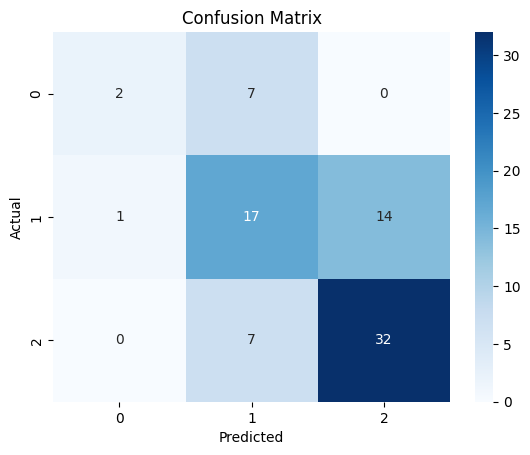

Accuracy :  0.6375
Precision :  0.6334852734922861


In [254]:
x = dataTotrain.drop(columns='Depression Level')
y = dataTotrain['Depression Level']
trainX,testX,trainY,testY = train_test_split(x,y,test_size=0.2,random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(trainX, trainY)

pred = model.predict(testX)

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(testY,pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(testY,pred)
print("Accuracy : ",accuracy)
precision = precision_score(testY,pred,average='weighted')
print("Precision : ",precision)

In [255]:
dataTotrain['Depression Level'].value_counts()

,count
Depression Level,
2,185
1,168
0,47


Even after this categorization the model have low accuracy and imbalance. So, the next approach is to convert the PHQ-9 score into categories as it has many number to categorize into various bins.

### **Model 3**

This approach involves binning the PHQ-9 scores to categories.

In [256]:
conversion_map = {
    **{i: 0 for i in range(0, 11)},      # 0–10 → 0 (Low)
    **{i: 1 for i in range(11, 15)},     # 11–14 → 1 (Moderate)
    **{i: 2 for i in range(15, 28)}      # 15–27 → 2 (High)
}

dataTotrain = df.copy()

dataTotrain['Depression_Level'] = dataTotrain['PHQ-9 Total Score'].map(conversion_map)
dataTotrain = dataTotrain.drop(columns=colToRemove)

dataTotrain['Depression_Level'].value_counts()

,count
Depression_Level,
2,185
1,144
0,71



Confusion Matrix:


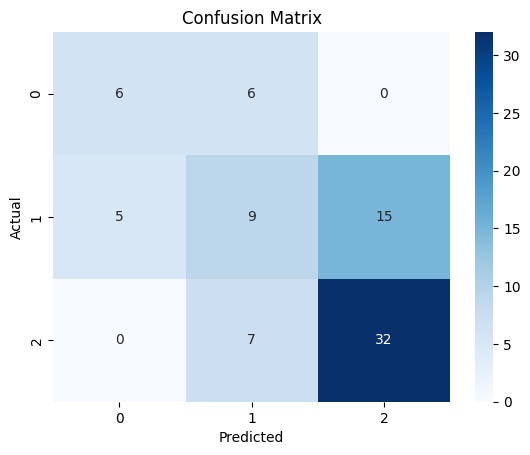

Accuracy :  0.5875
Precision :  0.5620285299806577


In [257]:
x = dataTotrain.drop(columns=['Depression_Level','Depression Level'])
y = dataTotrain['Depression_Level']
trainX,testX,trainY,testY = train_test_split(x,y,test_size=0.2,random_state=42)


model = RandomForestClassifier(random_state=42)
model.fit(trainX, trainY)

pred = model.predict(testX)

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(testY,pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(testY,pred)
print("Accuracy : ",accuracy)
precision = precision_score(testY,pred,average='weighted')
print("Precision : ",precision)

This model predictions are more ineffective than the previous with less imbalance in the categorize.

# **ADDITION OF NEW COLUMN**

In [263]:
colToRemoveForInstance = colToRemove
colToRemoveForInstance.remove('PHQ-9 Total Score')
df1 = df.drop(columns=colToRemoveForInstance)
df1['Scores'] = df1.iloc[:, 1:-2].sum(axis=1)
df1['ScoresAvg'] = df1.iloc[:, 1:4].mean(axis=1)

df1

,Little interest or pleasure in doing things?,"Trouble falling or staying asleep, or sleeping too much?",Poor appetite or overeating?,"Trouble concentrating on things, such as reading the newspaper or watching television?","Thoughts that you would be better off dead, or thoughts of hurting yourself in some way?",PHQ-9 Total Score,Depression Level,Scores,ScoresAvg
0,0,0,0,2,0,7,1,2,0.666667
1,1,2,1,3,3,19,3,9,2.000000
2,3,3,2,2,0,20,4,7,2.333333
3,3,3,2,0,3,17,3,8,1.666667
4,2,2,3,3,3,20,4,11,2.666667
...,...,...,...,...,...,...,...,...,...
395,1,2,3,3,1,19,3,9,2.666667
396,1,3,3,1,2,16,3,9,2.333333
397,1,2,2,2,2,13,2,8,2.000000
398,3,3,2,1,3,18,3,9,2.000000


In [264]:
correlation_matrix = df1.corr()
correlation_matrix['Depression Level'].sort_values(ascending=False)

,Depression Level
Depression Level,1.000000
PHQ-9 Total Score,0.925276
Scores,0.634781
ScoresAvg,0.579494
"Trouble falling or staying asleep, or sleeping too much?",0.369632
Poor appetite or overeating?,0.328892
Little interest or pleasure in doing things?,0.327275
"Trouble concentrating on things, such as reading the newspaper or watching television?",0.325786
"Thoughts that you would be better off dead, or thoughts of hurting yourself in some way?",0.314790


## **Model 5**

### Categorization


In [277]:
conversion_map = {
    **{i: 0 for i in range(0,12)},      # 0–10 → 0 (Low)
    **{i: 1 for i in range(12,16)},     # 11–14 → 1 (Moderate)
    **{i: 2 for i in range(16,27)}      # 15–27 → 2 (High)
}

dataTotrain = df1.copy()

dataTotrain['Depression Level'] = dataTotrain['PHQ-9 Total Score'].map(conversion_map)
dataTotrain = dataTotrain.drop(columns='PHQ-9 Total Score')

dataTotrain['Depression Level'].value_counts()

,count
Depression Level,
1,161
2,137
0,102


In [278]:
dataTotrain

,Little interest or pleasure in doing things?,"Trouble falling or staying asleep, or sleeping too much?",Poor appetite or overeating?,"Trouble concentrating on things, such as reading the newspaper or watching television?","Thoughts that you would be better off dead, or thoughts of hurting yourself in some way?",Depression Level,Scores,ScoresAvg
0,0,0,0,2,0,0,2,0.666667
1,1,2,1,3,3,2,9,2.000000
2,3,3,2,2,0,2,7,2.333333
3,3,3,2,0,3,2,8,1.666667
4,2,2,3,3,3,2,11,2.666667
...,...,...,...,...,...,...,...,...
395,1,2,3,3,1,2,9,2.666667
396,1,3,3,1,2,2,9,2.333333
397,1,2,2,2,2,1,8,2.000000
398,3,3,2,1,3,2,9,2.000000


### Model building

In [280]:
x = dataTotrain.drop('Depression Level',axis=1)
y = dataTotrain['Depression Level']
trainX,testX,trainY,testY = train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2]),
    y=dataTotrain['Depression Level']
)
print(dict(zip([0, 1, 2], weights)))

{0: np.float64(1.3071895424836601), 1: np.float64(0.8281573498964804), 2: np.float64(0.9732360097323601)}


Classification Report
              precision    recall  f1-score   support

           0       0.55      0.57      0.56        21
           1       0.50      0.44      0.47        32
           2       0.60      0.67      0.63        27

    accuracy                           0.55        80
   macro avg       0.55      0.56      0.55        80
weighted avg       0.55      0.55      0.55        80


Confusion Matrix:


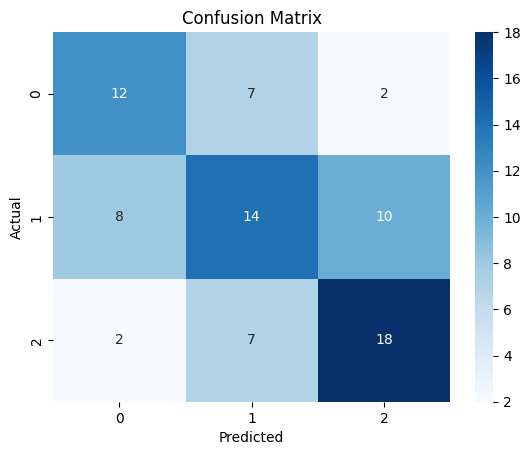

Accuracy : 0.55
Precision : 0.5456818181818182


In [283]:

finalmodel = RandomForestClassifier(class_weight=classWeight, random_state=42)
finalmodel.fit(trainX, trainY)

pred = finalmodel.predict(testX)

print("Classification Report")
print(classification_report(testY, pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(testY, pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(testY, pred)
print('Accuracy :', accuracy)
precision = precision_score(testY, pred, average='weighted')
print('Precision :', precision)

In [282]:
pipeline = Pipeline([
    ('rf', RandomForestClassifier(class_weight=classWeight, random_state=42))
])

scores = cross_val_score(pipeline, x, y, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Accuracy Scores: [0.575  0.55   0.525  0.4625 0.525 ]
Mean Accuracy: 0.5275


This is the best model that is going to be used for the mental health application

In [ ]:
!pip install joblib
import joblib

joblib.dump(finalmodel, 'mental_health_model.pkl')

Model has been converted into .pkl for backend use

In [ ]:
from google.colab import files
#files.download('mental_health_model.pkl')

In [ ]:
testX.describe()

In [ ]:
testY.describe()